In [1]:
import os
import omdb
import csv
import pickle
import collections
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
from networkx.algorithms import clique
from networkx.algorithms import cluster
from networkx.algorithms import link_prediction
from scipy.optimize import curve_fit
print(nx.__version__)

2.0


In [2]:
df = pickle.load(open("databasedump.pickle", 'rb'))

In [3]:
df.describe()

,actors,awards,box_office,country,director,genre,imdb_rating,imdb_votes,language,metascore,plot,production,rated,released,title,writer,year,title_director
count,15673,15673,15431,15673,15673,15673,15673,15673,15673,15673,15673,15431,15673,15673,15673,15673,15673,15673
unique,15267,2350,2900,1160,7035,949,82,10499,1338,98,14990,2089,23,8363,15646,13314,236,15673
top,N/A,N/A,N/A,USA,N/A,Drama,7.2,N/A,English,N/A,N/A,N/A,R,N/A,Early to Bed,N/A,2004,Boogie Nights: Paul Thomas Anderson
freq,231,5578,12402,8447,343,1153,683,350,9330,10322,667,3198,4584,653,2,870,538,1


In [4]:
#process dataframe into network
allActors = []
biGraph = nx.Graph()
actorSet = 0
movieSet = 1
count = 0

for index, row in df.iterrows():
    movie = row['title_director']
    biGraph.add_nodes_from([movie], bipartite=movieSet)
    actors = row['actors']
    if isinstance(actors, str):
        actors = actors.split(', ')
        #print(actors)
        for actor in actors:
            if not any(actor == name for name in allActors): # if actor is not in allActors already:
                allActors.append(actor)
                biGraph.add_nodes_from([actor], bipartite=actorSet)
                biGraph.add_edge(movie, actor, weight=1)
            else:
                #currWeight = biGraph[movie][actor]['weight']
                #print(actor)
                biGraph.add_edge(movie, actor, weight=1)
    count = count + 1
    #if count > 200:
    #    break


In [5]:
if(len(biGraph.nodes) > 50):
    print('too many nodes to plot in a reasonable amount of time')
else:
    nx.draw(biGraph)
    plt.show()

too many nodes to plot in a reasonable amount of time


In [6]:
movieNodes = set(n for n, d in biGraph.nodes(data=True) if d['bipartite']==movieSet)
actorNodes = set(n for n, d in biGraph.nodes(data=True) if d['bipartite']==actorSet)
print(len(movieNodes))
print(len(actorNodes))

15674
27352


In [7]:
len(biGraph['Mickey Rooney'])

21

In [15]:
biGraph['Inception: Christopher Nolan']['Leonardo DiCaprio']['weight']

1

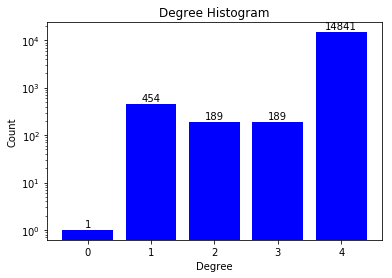

In [107]:
movieDegrees = sorted([d for n, d in biGraph.degree(movieNodes)])
#print(actorDegrees)
degreeCount = collections.Counter(movieDegrees)
degree, count = zip(*degreeCount.items())
fig, ax = plt.subplots()
bars = plt.bar(degree, count, width=0.80, color='b')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.yscale("log")
plt.xlabel("Degree")
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 1))

plt.show()

In [125]:
for actor in actorNodes:
    if biGraph.degree(actor) >= 50:
        print(actor + ": " + str(biGraph.degree(actor)))

Oliver Hardy: 50
N/A: 231
Mel Blanc: 87
Robert De Niro: 63
Michael Caine: 54
John Wayne: 61


In [124]:
len(biGraph['N/A'])

231

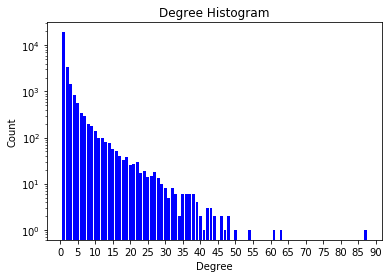

In [121]:
actorMovieDegrees = sorted([d for n, d in biGraph.degree(actorNodes)])
actorMovieDegrees = [i for i in actorMovieDegrees if i != len(biGraph['N/A'])]
#print(actorMovieDegrees)
degreeCount = collections.Counter(actorMovieDegrees)
degree, count = zip(*degreeCount.items())
fig, ax = plt.subplots()
bars = plt.bar(degree, count, width=0.80, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.yscale("log")
plt.xlabel("Degree")
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 5))

plt.show()

In [8]:
actorGraphUnweighted = nx.projected_graph(biGraph, actorNodes)
actorGraph = bipartite.weighted_projected_graph(biGraph, actorNodes)

In [75]:
print(actorGraph['James Franco']['Seth Rogen']['weight'])
print(len(actorGraph['James Franco']))

3
53


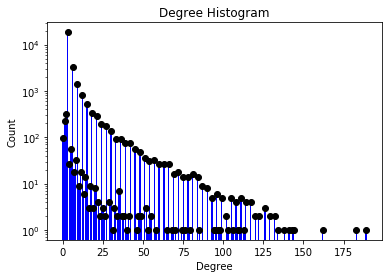

In [74]:
actorDegrees = sorted([d for n, d in actorGraph.degree(weight='weight')])
#print(actorDegrees)
degreeCount = collections.Counter(actorDegrees)
degree, count = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(degree, count, width=0.80, color='b')
plt.plot(degree, count, 'ko')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.yscale("log")
plt.xlabel("Degree")
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 25))

plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: divide by zero encountered in power
  from ipykernel import kernelapp as app


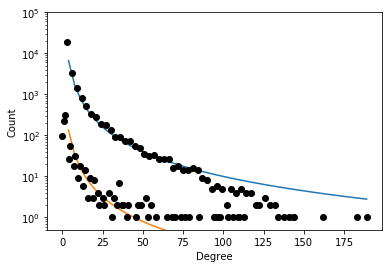

In [93]:
def func(x, a, b, c):
    return a*(x**-b) + c
    #return a*np.exp(-b*x)-c

#popt, pcov = curve_fit(func, degree, count, p0=(50000, 2, 1e-8), maxfev=50000)

xx = np.linspace(min(degree), max(degree))
yy = func(xx, 100000, 2, 0)
yyy = func(xx, 2000, 2, 0)
#yy = func(xx, *popt)

plt.plot(xx, yy)
plt.plot(xx, yyy)
plt.plot(degree, count, 'ko')
plt.yscale('log')
plt.ylabel("Count")
plt.xlabel("Degree")

plt.ylim([0.5, 10e4])
plt.show()

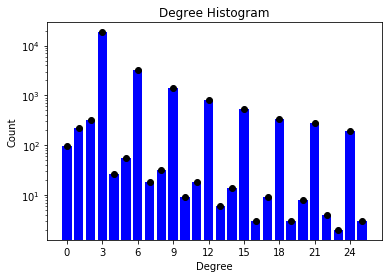

In [94]:
actorDegrees = sorted([d for n, d in actorGraph.degree(weight='weight')])
actorDegrees = [i for i in actorDegrees if i <=25]
#print(actorDegrees)
degreeCount = collections.Counter(actorDegrees)
degree, count = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(degree, count, width=0.80, color='b')
plt.plot(degree, count, 'ko')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.yscale("log")
plt.xlabel("Degree")
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 3))

plt.show()